## Import libraries:

In [1]:
from imports import *

## Import data

In [2]:
# Cargar archivo Parquet
table = pq.read_table("v0704_baseline_preproc.parquet")

# Convertir de Arrow Table a awkward Array
data_loaded = {name: ak.from_arrow(column) for name, column in zip(table.column_names, table.columns)}

# Acceder a las variables cargadas
nuvT = data_loaded["nuvT"]
f_ophit_PE = data_loaded["f_ophit_PE"]
f_ophit_ch = data_loaded["f_ophit_ch"]
f_ophit_t = data_loaded["f_ophit_t"]
dEpromx = data_loaded["dEpromx"]
dEpromy = data_loaded["dEpromy"]
dEpromz = data_loaded["dEpromz"]

In [3]:
dEprom = np.load("v0704_y_pred_resnet18.npy")

**Seleccionar los n primeros ophits de cada flash**

In [4]:
# Obtener los índices ordenados de manera creciente dentro de cada flash
sorted_indices = ak.argsort(f_ophit_t, axis=-1, ascending=True)
# Ordenar los datos de los ophits dentro de cada flash
f_ophit_t_sorted = f_ophit_t[sorted_indices]  # Ordenar f_ophit_t
f_ophit_PE_sorted = f_ophit_PE[sorted_indices]  # Reordenar PE
f_ophit_ch_sorted = f_ophit_ch[sorted_indices]  # Reordenar canales

In [5]:
def select_top_ophits(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, max_ophits_per_flash=1000):
    selected_t, selected_PE, selected_ch = [], [], []
    
    for event_idx in range(len(f_ophit_ch_sorted)):
        selected_event_t, selected_event_PE, selected_event_ch = [], [], []
        
        for flash_idx in range(len(f_ophit_ch_sorted[event_idx])):
            flash_ch = f_ophit_ch_sorted[event_idx][flash_idx]
            flash_t = f_ophit_t_sorted[event_idx][flash_idx]
            flash_PE = f_ophit_PE_sorted[event_idx][flash_idx]
            
            # Tomar solo los primeros 100 ophits
            selected_event_t.append(flash_t[:max_ophits_per_flash])
            selected_event_PE.append(flash_PE[:max_ophits_per_flash])
            selected_event_ch.append(flash_ch[:max_ophits_per_flash])
        
        selected_t.append(selected_event_t)
        selected_PE.append(selected_event_PE)
        selected_ch.append(selected_event_ch)
    
    return ak.Array(selected_t), ak.Array(selected_PE), ak.Array(selected_ch)

In [6]:
selected_ophits_t, selected_ophits_PE, selected_ophits_ch= select_top_ophits(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, max_ophits_per_flash=3)

### Corregir el ToF en las variables temporales

**importar nuvZ para que sea una predicción temporal de solo luz (esto es complicado ya que no puedo entrenar con estos entonces)**

In [20]:
nuvZ = dEprom[:,2]

In [27]:
#print(nuvT.shape)
print(nuvZ.shape)

(6620,)


In [ ]:
ToF_inside = nuvZ / 3E10 *1E9
#ToF_outside = 110 / 3E8 * 1E9
bunch_separation = 19

nuvT_c= nuvT - ToF_inside 
selected_ophits_t_c_1 = selected_ophits_t*1000 - ToF_inside
selected_ophits_t_c_2 = selected_ophits_t*1000 - ToF_inside - ak.flatten(nuvT_c)

### Crear el input para la LSTM

In [7]:
def pad_and_regularize(ak_array, num_ophits, num_flashes=4, pad_value=0.0):
    # Step 1: Pad ophits per flash (asegurar que cada flash tenga 100 ophits)
    ak_padded_ophits = ak.pad_none(ak_array, num_ophits, axis=-1, clip=True)
    ak_filled_ophits = ak.fill_none(ak_padded_ophits, pad_value)

    # Step 2: Pad flashes por evento (asegurar que cada evento tenga 4 flashes)
    ak_padded_flashes = ak.pad_none(ak_filled_ophits, num_flashes, axis=-2, clip=True)
    ak_filled = ak.fill_none(ak_padded_flashes, pad_value)

    # Step 3: Convertir a un array regular de NumPy
    np_array = ak.to_numpy(ak_filled)
    
    # Si el resultado es un masked array, rellenamos los valores faltantes con 0
    np_array = np.ma.filled(np_array, fill_value=-1000)

    return np_array

ophit_cut= 3

regular_ophit = pad_and_regularize(selected_ophits_t,num_ophits = ophit_cut)
regular_ch = pad_and_regularize(selected_ophits_ch, num_ophits = ophit_cut)
regular_PE = pad_and_regularize(selected_ophits_PE, num_ophits = ophit_cut)

regular_ophit_r = regular_ophit.reshape(regular_ophit.shape[0], 4*ophit_cut)
regular_ch_r = regular_ch.reshape(regular_ch.shape[0], 4*ophit_cut)
regular_pe_r = regular_PE.reshape(regular_PE.shape[0], 4*ophit_cut)

print(regular_ophit_r.shape)  # Forma esperada: (num_events, 4, n_ophits_per_flash)
print(regular_ch_r.shape)  # Forma esperada: (num_events, 4, n_ophits_per_flash)
print(regular_pe_r.shape)  # Forma esperada: (num_events, 4, n_ophits_per_flash)

(22067, 12)
(22067, 12)
(22067, 12)


**el channel_dict se puede realizar en 1 e importar despues donde sea necesario**

In [8]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


In [9]:
PDSMap = file['opanatree']['PDSMapTree']
channel_dict = {id_val: (int(type_val), round(float(x_val),2), round(float(y_val),2), round(float(z_val),2)) 
                for id_val, type_val, x_val, y_val, z_val in zip(PDSMap['OpDetID'].array()[0], 
                                                                  PDSMap['OpDetType'].array()[0], 
                                                                  PDSMap['OpDetX'].array()[0], 
                                                                  PDSMap['OpDetY'].array()[0], 
                                                                  PDSMap['OpDetZ'].array()[0])}


# Imprimir el diccionario resultante
print(channel_dict)

{0: (3, -213.75, -135.0, 20.25), 1: (3, 213.75, -135.0, 20.25), 2: (3, -213.75, 0.0, 20.25), 3: (3, 213.75, 0.0, 20.25), 4: (3, -213.75, 135.0, 20.25), 5: (3, 213.75, 135.0, 20.25), 6: (0, -213.4, -175.0, 27.87), 7: (0, 213.4, -175.0, 27.87), 8: (0, -213.4, -95.0, 27.87), 9: (0, 213.4, -95.0, 27.87), 10: (0, -213.4, -40.0, 27.87), 11: (0, 213.4, -40.0, 27.87), 12: (0, -213.4, 40.0, 27.87), 13: (0, 213.4, 40.0, 27.87), 14: (0, -213.4, 95.0, 27.87), 15: (0, 213.4, 95.0, 27.87), 16: (0, -213.4, 175.0, 27.87), 17: (0, 213.4, 175.0, 27.87), 18: (2, -213.75, -135.0, 35.49), 19: (2, 213.75, -135.0, 35.49), 20: (2, -213.75, 0.0, 35.49), 21: (2, 213.75, 0.0, 35.49), 22: (2, -213.75, 135.0, 35.49), 23: (2, 213.75, 135.0, 35.49), 24: (3, -213.75, -175.0, 50.25), 25: (3, 213.75, -175.0, 50.25), 26: (3, -213.75, -95.0, 50.25), 27: (3, 213.75, -95.0, 50.25), 28: (3, -213.75, -40.0, 50.25), 29: (3, 213.75, -40.0, 50.25), 30: (3, -213.75, 40.0, 50.25), 31: (3, 213.75, 40.0, 50.25), 32: (3, -213.75, 95

In [10]:
n_fotodetector = np.vectorize(lambda x: channel_dict.get(x, (-1000, -1000, -1000, -1000))[0])(regular_ch_r)
x_fotodetector = np.vectorize(lambda x: channel_dict.get(x, (-1000, -1000, -1000, -1000))[1])(regular_ch_r)
y_fotodetector = np.vectorize(lambda x: channel_dict.get(x, (-1000, -1000, -1000, -1000))[2])(regular_ch_r)
z_fotodetector = np.vectorize(lambda x: channel_dict.get(x, (-1000, -1000, -1000, -1000))[3])(regular_ch_r)

#n_tpc = np.where(regular_ch_r == -1000, -1000, np.where(regular_ch_r % 2 == 0, 0, 1))

In [11]:
# Función de normalización con redondeo a dos decimales
def normalize(values, min_val, max_val, target_range=(-1, 1)):
    # Filtrar los valores válidos (diferentes de -1000)
    valid_values = values[values != -1000]
    
    # Si hay valores válidos, calcular los valores mínimos y máximos
    if len(valid_values) > 0:
        min_valid = valid_values.min()
        max_valid = valid_values.max()
    else:
        min_valid = min_val
        max_valid = max_val
    
    # Normalizar los valores
    norm_values = (values - min_valid) / (max_valid - min_valid)
    
    # Ajustar al rango deseado
    if target_range == (-1, 1):
        norm_values = norm_values * 2 - 1  # Para el rango [-1, 1]
    elif target_range == (0, 1):
        norm_values = norm_values  # Para el rango [0, 1]
    
    # Devolver los valores normalizados, manteniendo los -1000 en su lugar
    norm_values[values == -1000] = -1000
    
    # Redondear los valores a dos decimales
    norm_values = np.round(norm_values, 2)
    
    return norm_values

# Normalización de las coordenadas x, y, z con redondeo a dos decimales
x_fotodetector_normalized = normalize(x_fotodetector, -1, 1)
y_fotodetector_normalized = normalize(y_fotodetector, -1, 1)
z_fotodetector_normalized = normalize(z_fotodetector, 0, 1, target_range=(0, 1))
regular_pe_r_normalized = normalize(regular_pe_r, 0, 1, target_range=(0, 1))

In [12]:
input = np.stack((regular_ophit_r, regular_pe_r_normalized, n_fotodetector, x_fotodetector_normalized, y_fotodetector_normalized,z_fotodetector_normalized), axis=2)
np.set_printoptions(suppress=True)

In [13]:
print(input[0])

[[    1.849     0.33      0.       -1.        1.        0.14 ]
 [    1.851     0.24      0.       -1.        1.        0.02 ]
 [    1.851     0.26      0.       -1.        0.54      0.02 ]
 [    1.88      0.03      2.       -1.        0.77      0.16 ]
 [    1.88      0.01      2.       -1.        0.77      0.32 ]
 [    1.88      0.03      2.       -1.        0.77      0.03 ]
 [-1000.    -1000.    -1000.    -1000.    -1000.    -1000.   ]
 [-1000.    -1000.    -1000.    -1000.    -1000.    -1000.   ]
 [-1000.    -1000.    -1000.    -1000.    -1000.    -1000.   ]
 [-1000.    -1000.    -1000.    -1000.    -1000.    -1000.   ]
 [-1000.    -1000.    -1000.    -1000.    -1000.    -1000.   ]
 [-1000.    -1000.    -1000.    -1000.    -1000.    -1000.   ]]


### Crear modelo

In [15]:
from sklearn.preprocessing import MinMaxScaler
# Flatten y convertir a numpy
nuvT_flat = ak.to_numpy(ak.flatten(nuvT))

# Asegurar que sea 2D para el scaler (scikit-learn requiere shape (n_samples, n_features))
nuvT_flat_2D = nuvT_flat.reshape(-1, 1)

# Escalamos
scaler = MinMaxScaler()
nuvT_scaled = scaler.fit_transform(nuvT_flat_2D)

# Si quieres volver a tenerlo en 1D
nuvT_scaled = nuvT_scaled.flatten()

In [16]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
X_train, X_test, y_train, y_test = train_test_split(input, nuvT_scaled, test_size=0.2)

In [37]:
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, ELU
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Mask is True where we want to KEEP the data (not -1000 in all features)
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

# Define the model with functional API
inputs = Input(shape=(4*ophit_cut,6))
masked_inputs, mask = MaskNegative1000()(inputs)

lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1, mask = mask)

x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 6)]      0           []                               
                                                                                                  
 mask_negative1000 (MaskNegativ  ((None, 12, 6),     0           ['input_1[0][0]']                
 e1000)                          (None, 12))                                                      
                                                                                                  
 lstm (LSTM)                    (None, 12, 256)      269312      ['mask_negative1000[0][0]',      
                                                                  'mask_negative1000[0][1]']      
                                                                                              

**Boosted**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, ELU, Attention
from tensorflow.keras.regularizers import l2

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Mask is True where we want to KEEP the data (not -1000 in all features)
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

# Define the model with functional API
inputs = Input(shape=(4*ophit_cut, 6))  # Assuming 'ophit_cut' is defined elsewhere
masked_inputs, mask = MaskNegative1000()(inputs)

# First LSTM Layer
lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs)

# Attention Layer - Apply attention to the output of the first LSTM
attention_out = Attention()([lstm_out1, lstm_out1])  # Self-attention on lstm_out1

# Residual Connection - Adding attention output with lstm_out1
residual_out = attention_out + lstm_out1  # Adding residual connection

# Second LSTM Layer
lstm_out2 = LSTM(128, return_sequences=False)(residual_out)

# Dense layer with L2 regularization
x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)

# Output Layer
outputs = Dense(1)(x)

# Create the model
model333 = Model(inputs, outputs)

# Compile the model
model333.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model333.summary()


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 12, 6)]      0           []                               
                                                                                                  
 mask_negative1000_15 (MaskNega  ((None, 12, 6),     0           ['input_16[0][0]']               
 tive1000)                       (None, 12))                                                      
                                                                                                  
 lstm_30 (LSTM)                 (None, 12, 256)      269312      ['mask_negative1000_15[0][0]']   
                                                                                                  
 attention_15 (Attention)       (None, 12, 256)      0           ['lstm_30[0][0]',         

**Boosted Plus (Parece que no mejora Boosted)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, Attention, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2

# Custom Masking Layer to handle values such as -1000
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Mask is True where we want to KEEP the data (not -1000 in all features)
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

# Define the model with functional API
inputs = Input(shape=(4 * ophit_cut, 6))  # Assuming 'ophit_cut' is defined elsewhere
masked_inputs, mask = MaskNegative1000()(inputs)

# First Bidirectional LSTM Layer
lstm_out1 = Bidirectional(LSTM(256, return_sequences=True))(masked_inputs)

# First Attention Layer - Apply attention to the output of the first LSTM
attention_out1 = Attention()([lstm_out1, lstm_out1])  # Self-attention on lstm_out1

# Residual Connection - Adding attention output with lstm_out1
residual_out1 = attention_out1 + lstm_out1  # Adding residual connection

# Second LSTM Layer with Dropout
lstm_out2 = LSTM(128, return_sequences=True)(residual_out1)
lstm_out2 = Dropout(0.3)(lstm_out2)  # Dropout for regularization

# Second Attention Layer
attention_out2 = Attention()([lstm_out2, lstm_out2])  # Self-attention on lstm_out2

# Residual Connection for the second LSTM
residual_out2 = attention_out2 + lstm_out2  # Adding residual connection

# Third LSTM Layer
lstm_out3 = LSTM(64, return_sequences=False)(residual_out2)

# Dense Layer with L2 regularization and BatchNormalization
x = Dense(64, kernel_regularizer=l2(0.01))(lstm_out3)
x = BatchNormalization()(x)  # BatchNormalization

# Output Layer
outputs = Dense(1)(x)

# Create the model
model_complex = Model(inputs, outputs)

# Compile the model
model_complex.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model_complex.summary()

In [82]:
y_pred, history= train_and_predict(model999, X_train, y_train, X_test, y_test, epochs=80, batch_size=16)

Epoch 1/80


2025-04-07 17:28:53.979991: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2025-04-07 17:28:53.980586: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" fr

1102/1104 [============================>.] - ETA: 0s - loss: 0.1134 - mae: 0.0459

2025-04-07 17:29:03.804818: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2025-04-07 17:29:03.805066: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" fr

1104/1104 [==============================] - 15s 9ms/step - loss: 0.1133 - mae: 0.0459 - val_loss: 0.0047 - val_mae: 0.0415 - lr: 0.0010
Epoch 2/80
1104/1104 [==============================] - 10s 9ms/step - loss: 0.0028 - mae: 0.0299 - val_loss: 0.0022 - val_mae: 0.0265 - lr: 0.0010
Epoch 3/80
1104/1104 [==============================] - 10s 9ms/step - loss: 0.0023 - mae: 0.0264 - val_loss: 0.0019 - val_mae: 0.0201 - lr: 0.0010
Epoch 4/80
1104/1104 [==============================] - 9s 8ms/step - loss: 0.0021 - mae: 0.0243 - val_loss: 0.0036 - val_mae: 0.0377 - lr: 0.0010
Epoch 5/80
1104/1104 [==============================] - 9s 9ms/step - loss: 0.0020 - mae: 0.0231 - val_loss: 0.0017 - val_mae: 0.0189 - lr: 0.0010
Epoch 6/80
1104/1104 [==============================] - 9s 8ms/step - loss: 0.0020 - mae: 0.0234 - val_loss: 0.0015 - val_mae: 0.0149 - lr: 0.0010
Epoch 7/80
1104/1104 [==============================] - 9s 8ms/step - loss: 0.0018 - mae: 0.0206 - val_loss: 0.0022 - val_mae:

2025-04-07 17:32:23.135991: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2025-04-07 17:32:23.136557: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" fr

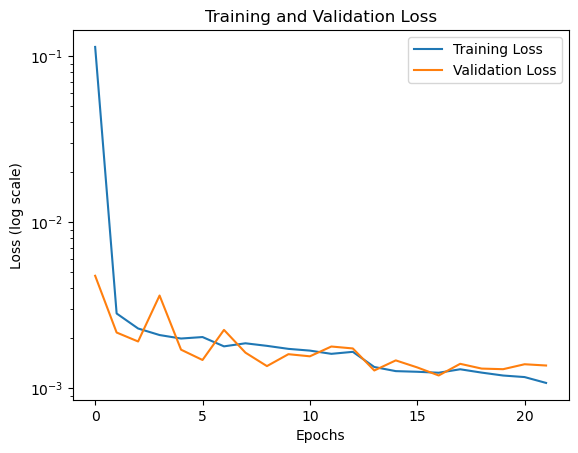

In [83]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [84]:
# Ahora, para hacer el inverse transform y obtener los valores originales
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

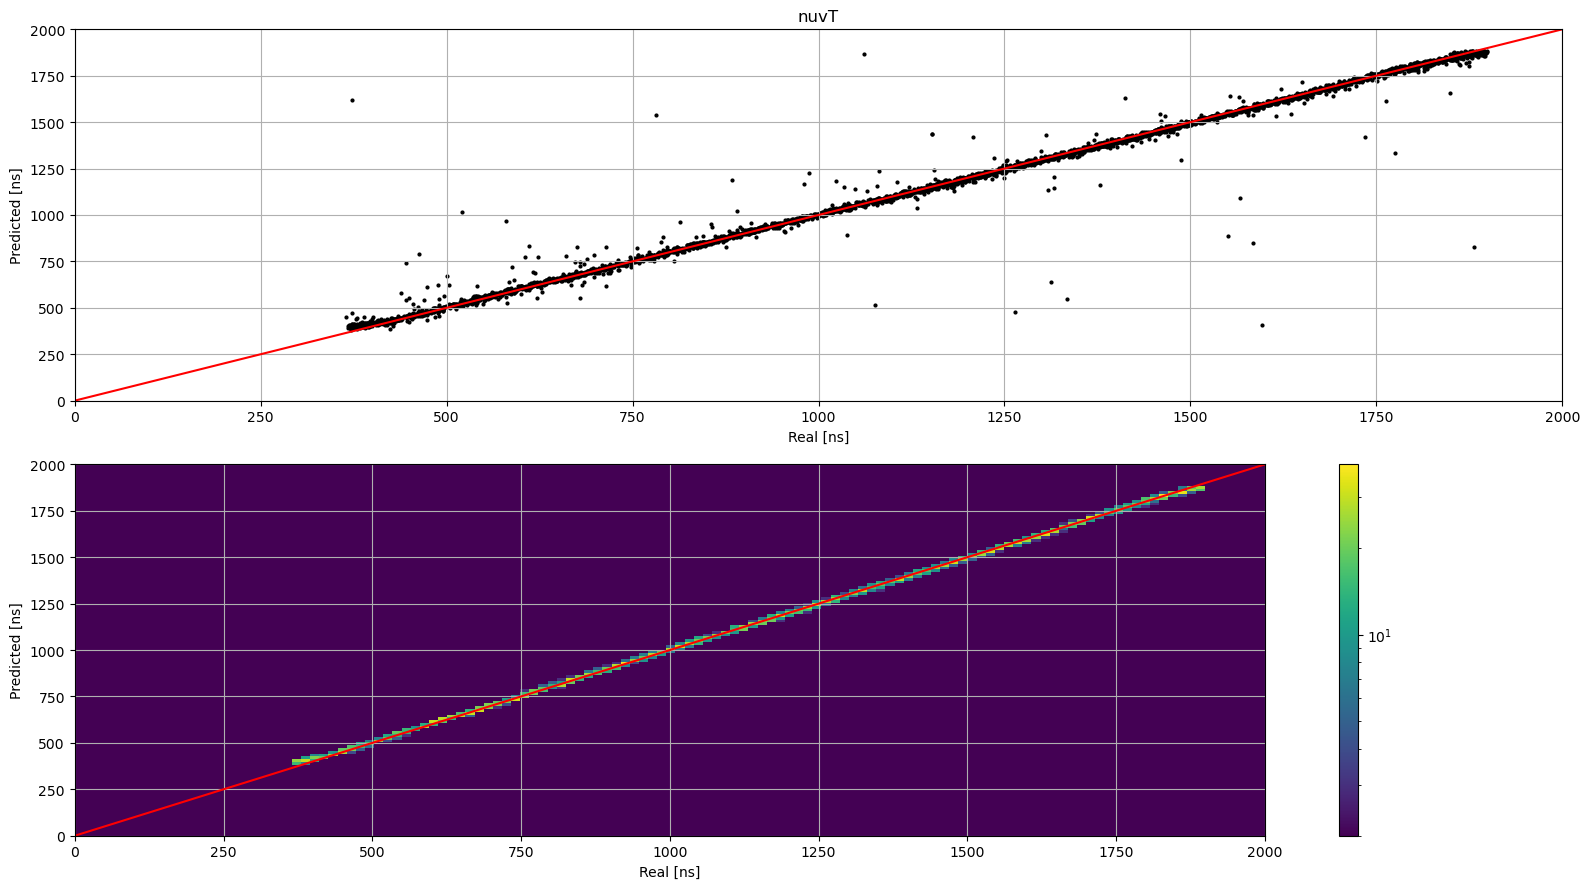

In [85]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,1,figsize=(16,9))

axs[0].scatter(y_test_inverse, y_pred_inverse, color="black",s=4)
axs[0].grid()

axs[0].plot([0,2000],[0,2000],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,2000])
axs[0].set_ylim([0,2000])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

im0 = axs[1].hist2d(y_test_inverse.flatten(), y_pred_inverse.flatten(), bins=(100, 100), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,2000],[0,2000],'r')
axs[1].set_xlim([0,2000])
axs[1].set_ylim([0,2000])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')



fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

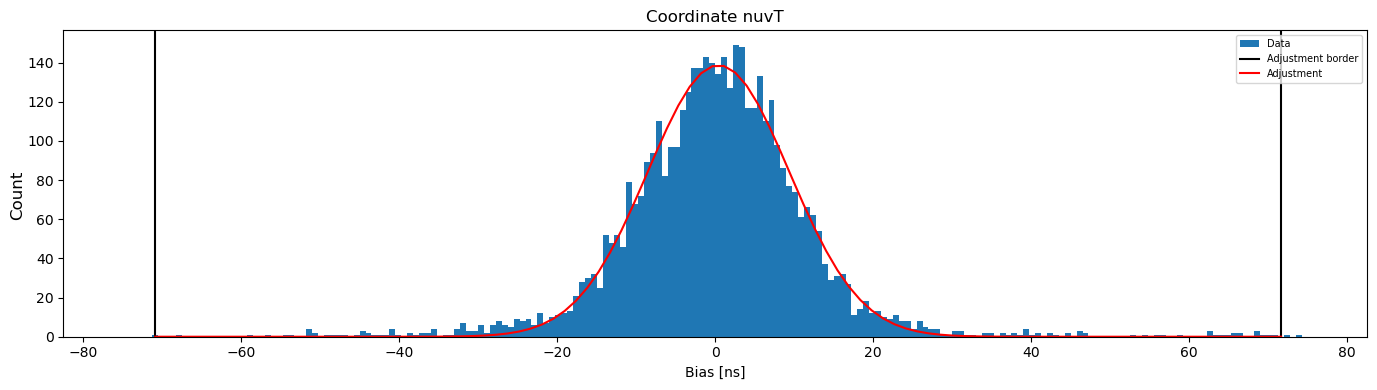

Bias Adjustment variables
------------------
Mean nuvT = 0.43
Sigma nuvT = 8.97
------------------


In [86]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = ak.flatten(y_pred_inverse) - ak.flatten(y_test_inverse)

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, ax, coord_name, ini, fin, hist_range):
    counts, bins, patches = ax.hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    ax.axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    ax.axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    ax.plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    ax.set_xlabel('Bias [ns]')  # Set different xlabel for nuvT
    ax.set_title(f'Coordinate {coord_name}')
    ax.legend(prop={"size": 7})

    return popt

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(14, 4))

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, ax, 'nuvT', 5, 195, hist_range=[-75, 75])

# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')


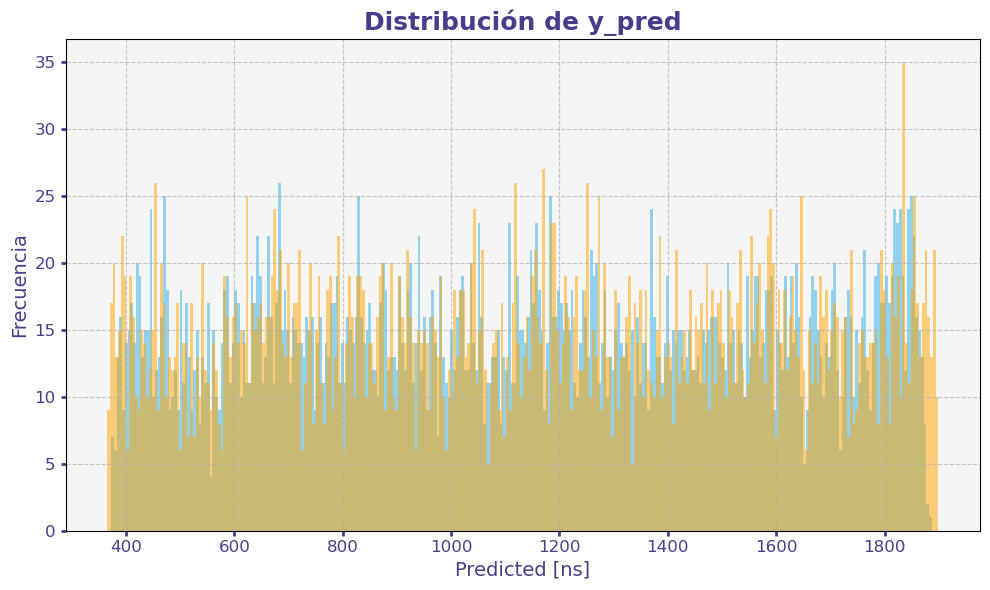

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Asegúrate de que y_pred esté en formato correcto


plt.figure(figsize=(10, 6))

# Estilo del histograma
plt.hist(y_pred_inverse, bins=300, color='skyblue', alpha=0.9)
plt.hist(y_test_inverse, bins=300, color='orange', alpha=0.5)

# Títulos y etiquetas con un toque de estilo
plt.title('Distribución de y_pred', fontsize=18, fontweight='bold', color='darkslateblue')
plt.xlabel('Predicted [ns]', fontsize=14, color='darkslateblue')
plt.ylabel('Frecuencia', fontsize=14, color='darkslateblue')

# Mejorar la estética del gráfico
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12, width=2, colors='darkslateblue')

# Añadir un fondo suave al gráfico
plt.gca().set_facecolor('whitesmoke')

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()
